## Week 3: Using Hough-transform to find traffic sign regions


This week, we will look at how Hough-transform can be used to find the shapes of traffic signs: from line segments to triangles and rectangles, and detecting circles. 

### Task 1: Edge detection
The Hough-transform is normally computed from tresholded edge magnitude images, so the first step is to compute the Sobel magnitude, perhaps also combined with smoothing using a lowpass filter. 
    


First, let us select an image to experiment with



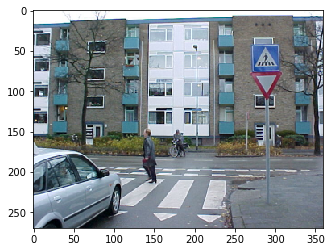

In [27]:
from imageio import imread

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
imfile = "images/pedestrian_005.png"
#imfile = "images/bike_002.png"
im1 = imread(imfile)

#img=mpimg.imread('your_image.png')
imgplot = plt.imshow(im1)
plt.show()

In [28]:
import matplotlib.cm as cm
grayimage = (0.3*im1[:,:,0]+0.6*im1[:,:,1]+0.1*im1[:,:,2])

imgplot = plt.imshow(grayimage,cmap=cm.gray)
#imgplot = plt.imshow(im1[:,:,0],cmap=cm.gray)

Consider using e.g. matplotlib.colors.rgb_to_hsv() to convert from RGB to HSV and use the V-channel in HSV. Display the V-component and get an opinion if it is better than the grayscale conversion you did above. Is the H or S component useful?

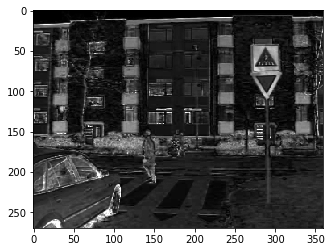

In [29]:
from matplotlib.colors import rgb_to_hsv
hsvim = rgb_to_hsv(im1)
imgplt=plt.imshow(hsvim[:,:,1],cmap=cm.gray)

## Apply edge detection using the Sobel operator to the image

Let us implement a Sobel operator using the ndimage package (or implement convolution from scratch).
Work on your selected grayscale image.
Compute the sobel magnitude image and display it. 


Since image convolution is a commutative operator, we can create a larger Sobel mask by first convolving the image with a smoothing filter (Gaussian or mean) of a given size, and then convolve this result with the Sobel. Try using mean filters of different size before the Sobel 


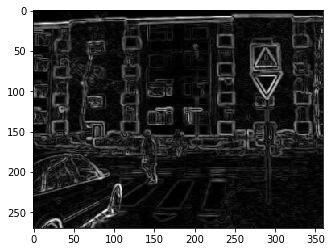

In [30]:
from scipy import ndimage
import numpy as np
from skimage import color
from skimage import filters

img = hsvim[:,:,1]
#img = grayimage

img = filters.gaussian(img, sigma=0.9)
gx = ndimage.sobel(img, 0)  # horizontal derivative
gy = ndimage.sobel(img, 1)  # vertical derivative
sobeledge = np.zeros(gx.shape)
sobeledge = np.arctan2(gx,gy)
sobelmag = np.hypot(gx, gy)  # magnitude
sobelmag *= 255.0 / np.max(sobelmag)  # normalize (Q&D)
imgplt=plt.imshow(sobelmag,cmap = cm.gray)


# We could also check if the Laplacian is better
#log_img = filters.laplace(img, ksize=15)
#imgplt = plt.imshow(log_img,cmap=cm.gray)
#logmax = log_img.max()
#print(logmax)
#log_negate = logmax-log_img
#imgplt1 = plt.imshow(log_negate,cmap=cm.gray)






 Check the Sobel edge direction. 
 
 Question: How could we use this to compute the rho/theta domain faster?

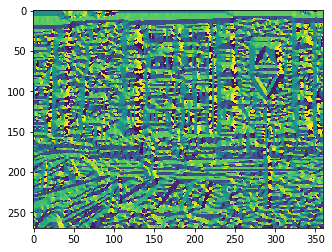

In [31]:
# Check the Sobel edge direction, too
imgplt2 = plt.imshow(sobeledge)

## Task 2: thresholding the  edge magnitude images

Thesholding these might be a bit challenging, since they are not bimodal. Remember, we want to find a threshold that work for many images. 



Threshold found:  100


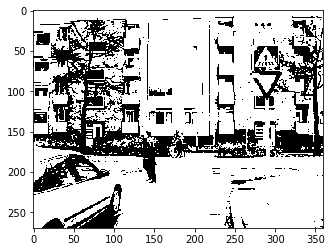

In [32]:
# Try various thresholding methods from skimage.filters
from skimage import filters
img = sobelmag
#img = hsvim[:,:,1]*255
val = filters.threshold_otsu(img)
val = 100
otsu_img = grayimage > val

print("Threshold found: ", val)

imgplt=plt.imshow(otsu_img,cmap = cm.gray)

### Try also adaptive thresholding

Consider trying adaptive thresholding (e.g. skimage.filter.threshold_local)  if global thresholding does not work.  Also experiment with using the graylevel image or one of the HSV-components as input. Try different window sizes in local thresholding. 


In [33]:
# Try various thresholding methods from skimage.filters
from skimage import filters
img = sobelmag
#img = hsvim[:,:,2]*255

localth = img > filters.threshold_local(img, 115, 'mean')


imgplt=plt.imshow(localth,cmap = cm.gray)

In [34]:
# Try various thresholding methods from skimage.filters
from skimage import filters
img = localth
#img = hsvim[:,:,1]*255
#val = filters.threshold_otsu(img)
val = 0.43
otsu_img = img > val

print("Threshold found: ", val)

imgplt=plt.imshow(otsu_img,cmap = cm.gray)

Threshold found:  0.43


 Finding a good threshold automatically seems to be a bottleneck.

### Calculate Hough-transform 
Select a range for $\rho,\theta$ and calculate the Hough transform from the edge image

(270, 360, 3)


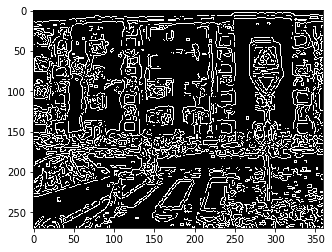

In [35]:
## First, test the Canny edge detector as suggested in the lecture
import cv2

#img = grayimage
print(hsvim.shape)
smooth = (filters.gaussian(img, sigma=0.9))
smooth = np.uint8(smooth/np.max(smooth)*255)
#imgplt1=plt.imshow(hsv1)
#print(hsvim.dtype)
#hue3 = np.zeros(hsvim.shape)
#hue3[:,:,0] = hsvim[:,:,1]
#hue3[:,:,1] = hsvim[:,:,1]
#hue3[:,:,2] = hsvim[:,:,1]
#gray1 = cv2.cvtColor(hue3,cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(smooth,50,150,apertureSize = 3)

imgplt=plt.imshow(edges,cmap=cm.gray)



#edges = cv2.Canny(gray,100,200,apertureSize = 3)
#cv2.imshow('edges',edges)
#cv2.waitKey(0)



#lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
#for x1,y1,x2,y2 in lines[0]:
#    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
#lines = cv2.HoughLines(edges,1,np.pi/180,200)
#minLineLength = 100
#maxLineGap = 10
#lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
#for x1,y1,x2,y2 in lines[0]:
#    cv2.line(im1,(x1,y1),(x2,y2),(0,255,0),2)
#
#imgplt = plt.imshow(img)

In [36]:
minLineLength = 20
maxLineGap = 10
# Change here which thresholded image we compute the Hough-transform from
hough_input = img = np.uint8(localth)
lines = cv2.HoughLinesP(hough_input,1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)



853


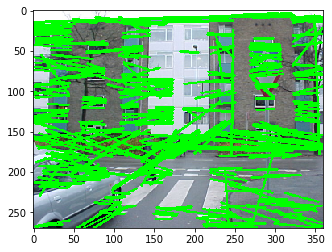

In [37]:
print(len(lines))
img2 = im1
img= localth
#for x in range(0, int(len(lines)/50)):
#Overlay the most dominant lines on the input image
noflines = 300
for x in range(0, noflines):
    for x1,y1,x2,y2 in lines[x]:
        #This tells us which image we will overlay the lines on
        cv2.line(img2,(x1,y1),(x2,y2),(0,255,0),2)
        #cv2.line(hough_input,(x1,y1),(x2,y2),(130),1)

imgplt=plt.imshow(img2,cmap=cm.gray)


Try detecting line in a local subwindow. 


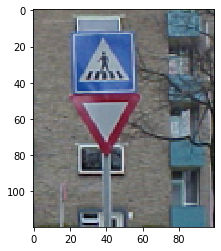

In [38]:
# As the previous lineplot has overlaid lines on the input image, read again:
#imfile = "images/pedestrian_005.png"
orig = imread(imfile)
orig_sub = orig[30:150,250:350]
hough_sub = hough_input[30:150,250:350]
imgplt = plt.imshow(orig_sub,cmap=cm.gray)

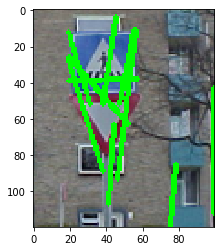

In [39]:
minLineLength = 30
maxLineGap = 5
# Change here which thresholded image we compute the Hough-transform from

sublines = cv2.HoughLinesP(hough_sub,1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)
noflines = 20
for x in range(0, noflines):
    for x1,y1,x2,y2 in sublines[x]:
        #This tells us which image we will overlay the lines on
        cv2.line(orig_sub,(x1,y1),(x2,y2),(0,255,0),2)
        #cv2.line(hough_input,(x1,y1),(x2,y2),(130),1)

imgplt=plt.imshow(orig_sub)


### Using Hough to detect circles using cv2.HoughCircles. Play around with input images and the parameters

In [45]:
image = cv2.imread("images/bike_004.png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
output = image.copy()
hsvim = rgb_to_hsv(image)
inim = np.uint8(hsvim[:,:,1])
inim = np.uint8(gray)
circles = cv2.HoughCircles(inim, cv2.HOUGH_GRADIENT, 5, 100, minRadius=20, maxRadius=40)
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
#cv2.imshow("output", np.hstack([image, output]))
 
plt.imshow(output)    


## Summary of attempts

In this notebook we have explored Hough transform for detecting line segments and circles.

It was surprisingly difficult to detect the correct line segments.

Circle detection worked better, if good parameters were given.



